# Python ERS 測試

## 顯示 Python ERS值

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp
from mediapipe.python.solutions.drawing_utils import _normalized_to_pixel_coordinates as denormalize_coordinates

import time
from playsound import playsound


mp_facemesh = mp.solutions.face_mesh
mp_drawing  = mp.solutions.drawing_utils
denormalize_coordinates = mp_drawing._normalized_to_pixel_coordinates
 
%matplotlib inline

In [ ]:
# The chosen 12 points:   P1,  P2,  P3,  P4,  P5,  P6
chosen_left_eye_idxs  = [362, 385, 387, 263, 373, 380]
chosen_right_eye_idxs = [33,  160, 158, 133, 153, 144]
all_chosen_idxs = chosen_left_eye_idxs + chosen_right_eye_idxs

def distance(point_1, point_2):
    """Calculate l2-norm between two points"""
    dist = sum([(i - j) ** 2 for i, j in zip(point_1, point_2)]) ** 0.5
    return dist

def get_ear(landmarks, refer_idxs, frame_width, frame_height):
    """
    Calculate Eye Aspect Ratio for one eye.
 
    Args:
        landmarks: (list) Detected landmarks list
        refer_idxs: (list) Index positions of the chosen landmarks
                            in order P1, P2, P3, P4, P5, P6
        frame_width: (int) Width of captured frame
        frame_height: (int) Height of captured frame
 
    Returns:
        ear: (float) Eye aspect ratio
    """
    try:
        # Compute the euclidean distance between the horizontal
        coords_points = []
        for i in refer_idxs:
            lm = landmarks[i]
            coord = denormalize_coordinates(lm.x, lm.y, 
                                             frame_width, frame_height)
            coords_points.append(coord)
 
        # Eye landmark (x, y)-coordinates
        P2_P6 = distance(coords_points[1], coords_points[5])
        P3_P5 = distance(coords_points[2], coords_points[4])
        P1_P4 = distance(coords_points[0], coords_points[3])
 
        # Compute the eye aspect ratio
        ear = (P2_P6 + P3_P5) / (2.0 * P1_P4)
 
    except:
        ear = 0.0
        coords_points = None
 
    return ear, coords_points

def calculate_avg_ear(landmarks, left_eye_idxs, right_eye_idxs, image_w, image_h):
    """Calculate Eye aspect ratio"""
 
    left_ear, left_lm_coordinates = get_ear(
                                      landmarks, 
                                      left_eye_idxs, 
                                      image_w, 
                                      image_h
                                    )
    right_ear, right_lm_coordinates = get_ear(
                                      landmarks, 
                                      right_eye_idxs, 
                                      image_w, 
                                      image_h
                                    )
    Avg_EAR = (left_ear + right_ear) / 2.0
 
    return Avg_EAR, (left_lm_coordinates, right_lm_coordinates)

In [ ]:
def get_mediapipe_app(
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
):
    """Initialize and return Mediapipe FaceMesh Solution Graph object"""
    face_mesh = mp.solutions.face_mesh.FaceMesh(
        max_num_faces=max_num_faces,
        refine_landmarks=refine_landmarks,
        min_detection_confidence=min_detection_confidence,
        min_tracking_confidence=min_tracking_confidence,
    )
 
    return face_mesh

In [ ]:
# Create a VideoCapture object to read from the default camera
cap = cv2.VideoCapture(0)

# Set the desired frame rate
frame_rate = 30
prev_frame_time = 0

ear_values = []

# Create a FaceMesh object
with mp.solutions.face_mesh.FaceMesh(refine_landmarks=True) as face_mesh:
    # Initialize variables
    closed_eye_frame = 0
    eyes_open = True
    trigger_alarm = False

    while True:
        # Clear the camera's frame buffer
        cap.grab()

        # Calculate the time elapsed since the last frame was processed
        time_elapsed = time.time() - prev_frame_time

        # If enough time has elapsed, read the current frame and process it
        if time_elapsed > 1.0 / frame_rate:
            # Update the previous frame time
            prev_frame_time = time.time()

            # Read the current frame from the camera
            ret, frame = cap.read()

            # If the frame was read successfully, process it
            if ret:
                # Convert the frame from BGR to RGB format
                image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                # Get the image dimensions
                imgH, imgW, _ = image.shape

                # Run face mesh detection on the current frame
                results = face_mesh.process(image).multi_face_landmarks

                # If detections are available.
                if results:
                    for face_id, face_landmarks in enumerate(results):
                        landmarks = face_landmarks.landmark
                        EAR, _ = calculate_avg_ear(
                                landmarks, 
                                chosen_left_eye_idxs, 
                                chosen_right_eye_idxs, 
                                imgW, 
                                imgH
                            )
                        cv2.putText(image, 
                                    f"EAR: {EAR:^1.02f}", (1, 80),
                                    cv2.FONT_HERSHEY_COMPLEX, 
                                    0.9, (255, 255, 255), 2
                        )
                        # 将 EAR 值添加到列表中
                        ear_values.append(EAR)

                        # Check if eyes are closed
                        if EAR < 0.14:
                            closed_eye_frame += 1
                            eyes_open = False
                        else:
                            eyes_open = True
                            closed_eye_frame = 0

                        # Print the closed eye frame count on the current frame.
                        cv2.putText(image, 
                                    f"Closed Eyes: {closed_eye_frame}", (1, 50),
                                    cv2.FONT_HERSHEY_COMPLEX, 
                                    0.9, (255, 255, 255), 2
                        )

                        # If eyes are closed for more than 15 frames (0.5 seconds), sound an alarm
                        if not eyes_open and closed_eye_frame > 15:
                            cv2.putText(image, "ALERT: Eyes Closed!", (imgW // 2 - 100, imgH // 2),
                                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

                # Display the frame in a window
                cv2.imshow('Frame', image)

            # Exit the loop if the 'q' key is pressed
            if cv2.waitKey(1) == ord('q'):
                break

# When everything done, release the capture
cap.release()
# Destroy the all windows now
cv2.destroyAllWindows()
print(ear_values)  # 输出 EAR 值列表

[0.28083642365285266, 0.28177112669787896, 0.297624533975855, 0.3100176147912421, 0.33125081257185574, 0.32179169221042836, 0.29446116387116505, 0.3087334223071288, 0.2628420123194742, 0.10907479006946835, 0.12775800512855662, 0.22519306889904772, 0.26642038514742317, 0.27559289633832446, 0.30054205717003657, 0.26957079619347735, 0.3052086265603526, 0.30474444820440955, 0.32407808475346017, 0.34161810580511814, 0.333508694748462, 0.37748243972226264, 0.35422509790284895, 0.2981395737351036, 0.29900996619281744, 0.30024692779196566, 0.2922524856730357, 0.30069423292607494, 0.2993182388014844, 0.2826759915514836, 0.2739109679931934, 0.3048587335789501, 0.2891389407364015, 0.29604773330761236, 0.2931243116492243, 0.278723353716121, 0.2860207290273371, 0.2765384509716464, 0.28436226950140747, 0.29113630250994704, 0.2888094080925688, 0.2773948234431261, 0.27245718587162365, 0.20837072850559293, 0.14328752105724224, 0.23830120832138058, 0.25325074101776146, 0.26491697709672707, 0.25129682098

## EAR 圖表

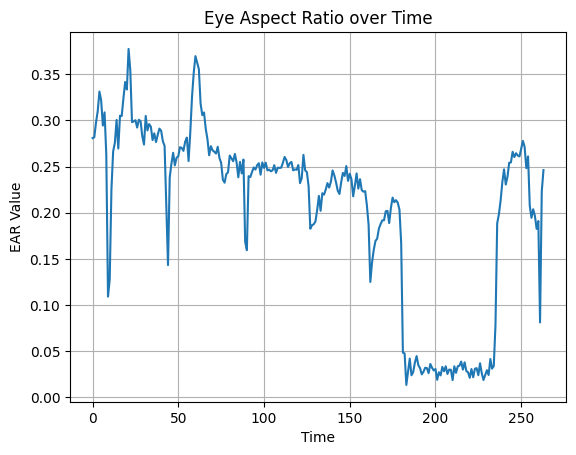

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# 示例 EAR 值列表（请替换为你的实际数据）
ear_values = [0.28083642365285266, 0.28177112669787896, 0.297624533975855, 0.3100176147912421, 0.33125081257185574, 0.32179169221042836, 0.29446116387116505, 0.3087334223071288, 0.2628420123194742, 0.10907479006946835, 0.12775800512855662, 0.22519306889904772, 0.26642038514742317, 0.27559289633832446, 0.30054205717003657, 0.26957079619347735, 0.3052086265603526, 0.30474444820440955, 0.32407808475346017, 0.34161810580511814, 0.333508694748462, 0.37748243972226264, 0.35422509790284895, 0.2981395737351036, 0.29900996619281744, 0.30024692779196566, 0.2922524856730357, 0.30069423292607494, 0.2993182388014844, 0.2826759915514836, 0.2739109679931934, 0.3048587335789501, 0.2891389407364015, 0.29604773330761236, 0.2931243116492243, 0.278723353716121, 0.2860207290273371, 0.2765384509716464, 0.28436226950140747, 0.29113630250994704, 0.2888094080925688, 0.2773948234431261, 0.27245718587162365, 0.20837072850559293, 0.14328752105724224, 0.23830120832138058, 0.25325074101776146, 0.26491697709672707, 0.25129682098567163, 0.25956257055414267, 0.26119875483768806, 0.2709983357352084, 0.2702475108284326, 0.26701418760114287, 0.276921782079616, 0.28142235893483314, 0.2560280842128269, 0.2875240900135993, 0.32538009798811784, 0.35161916800927595, 0.36971602545146076, 0.3627944960763637, 0.35557271525504847, 0.31823997306104845, 0.3057066781177823, 0.30866045682193294, 0.29099597866455085, 0.2797559130653418, 0.26226801734413385, 0.27207873819231626, 0.26764211016157824, 0.266057074489395, 0.26412909108892474, 0.2714660432464069, 0.25933726874209007, 0.2540069322680143, 0.23575265133345136, 0.2325468916188915, 0.24178144280978714, 0.24382801526271014, 0.261940376889593, 0.2589326304049765, 0.25582136021019586, 0.263715462289117, 0.25446042451433937, 0.23842747179862683, 0.25507127676170616, 0.2425952032623236, 0.25759437425685094, 0.16855739813354742, 0.1594020960334506, 0.23963390635765847, 0.23857318072840455, 0.24413280896643116, 0.24900247486676996, 0.2467699990015301, 0.25150706119841, 0.25363599458504194, 0.24122551020463118, 0.25447761478697206, 0.24858430767676432, 0.25423714156659016, 0.24579867096587427, 0.2467101877098739, 0.2448825277914444, 0.2459658139914174, 0.2515095997212271, 0.24318564177797777, 0.2487992523852931, 0.2485730037638597, 0.24880402196270035, 0.254078933456706, 0.2604031859341589, 0.257137721329818, 0.249608801007618, 0.25360058067691055, 0.2550539411130095, 0.2459154026134148, 0.2469323543326617, 0.24656652092303027, 0.25168393084604435, 0.23204163784953863, 0.2375693198606598, 0.2626942791676416, 0.24589344088734783, 0.2439810051058312, 0.22862696455174153, 0.18266469535040236, 0.1864683083512285, 0.1875238547908516, 0.19053880323689226, 0.20298052269947484, 0.21819115698025054, 0.20204137244745793, 0.22112439593032068, 0.21955891854626208, 0.2251735015922805, 0.23210563172826598, 0.22724283728065506, 0.23364430305314005, 0.2458493606727493, 0.24043593732806076, 0.2329404072470192, 0.22386842844751786, 0.2202939555956247, 0.23292444538123208, 0.2431825524435987, 0.23983831207161385, 0.2505235552187851, 0.23447637128831023, 0.24220861778259978, 0.23618502283949624, 0.21775633318005305, 0.22948397649912214, 0.24258843976577482, 0.22608613610231393, 0.23632697074275483, 0.22440603448441354, 0.2228014806873615, 0.22339939878208737, 0.207931032608351, 0.1867890432203898, 0.12497946419107499, 0.14605868523290558, 0.15980717349716952, 0.169386154077576, 0.17191410914180563, 0.18277276618951546, 0.18776138155849448, 0.1917028740034697, 0.19183970980855708, 0.20155071343259817, 0.2020187927546397, 0.18876267837100227, 0.20511356094377362, 0.2164107280854662, 0.21136780046266385, 0.21362249023839036, 0.2108427058843399, 0.20331251364805175, 0.16686782321215948, 0.04838164991447113, 0.04757897160460576, 0.013408987116370409, 0.02760326584878115, 0.04193905892378427, 0.02384634121494595, 0.02713548199454791, 0.03764365069448794, 0.044646611512953835, 0.03481064179957231, 0.031594092688464116, 0.024854612778150785, 0.027631088307949515, 0.032034571108355864, 0.031622525143373326, 0.026201253328902864, 0.03608807016472511, 0.032034571108355864, 0.029038490059426457, 0.03062568031673211, 0.01892603916949332, 0.027148346432018196, 0.023700078826902143, 0.032926711891425514, 0.028170705114067773, 0.03362548955187381, 0.025240220289618597, 0.030030645223131425, 0.029809694328589938, 0.018651363513107852, 0.03360868474244235, 0.02648038678706914, 0.03362548955187381, 0.03422729575786146, 0.03873769265557307, 0.030022175620910536, 0.03791382082391673, 0.028380514032911544, 0.027147019447844485, 0.021112179992030515, 0.03065457131242122, 0.021695699750213036, 0.030942794298772856, 0.031622525143373326, 0.023937044040568005, 0.03686225058993211, 0.02617340336486896, 0.018765417290469558, 0.02393839737530652, 0.02937189622761041, 0.02415786985381878, 0.04146623899878045, 0.031046678649209118, 0.03384537253963163, 0.07801860336185015, 0.18842994305997507, 0.19846187071125426, 0.2132609174750798, 0.23315766351717643, 0.24701105916122817, 0.23055330935110455, 0.2389387427619406, 0.2541591282936624, 0.2545044371190608, 0.2660192472462599, 0.2602984202190634, 0.2644795652028711, 0.26192733285208125, 0.2609956033438294, 0.2694971549629418, 0.27782982736044004, 0.27132908973642245, 0.2483086180071498, 0.2610244995384671, 0.2074376030289482, 0.1944521014292106, 0.20376570947903966, 0.19646976241212938, 0.18247535958715955, 0.19101771612614218, 0.08113918239624276, 0.22335666058449433, 0.24621169491766312]
time_intervals = range(len(ear_values))  # 时间间隔（可以是整数或日期时间）

# 绘制 EAR 值图表
plt.plot(time_intervals, ear_values)
plt.xlabel('Time')
plt.ylabel('EAR Value')
plt.title('Eye Aspect Ratio over Time')
plt.grid(True)

# 保存图表为图像文件
plt.savefig('ear_chart.png')

# 显示图表
plt.show()


In [3]:
import cv2
import mediapipe as mp
import numpy as np       # 載入 numpy 函式庫

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)

cap = cv2.VideoCapture(0)

with mp_face_mesh.FaceMesh(
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as face_mesh:

    if not cap.isOpened():
        print("Cannot open camera")
        exit()
    while True:
        ret, img = cap.read()
        if not ret:
            print("Cannot receive frame")
            break
        img = cv2.resize(img,(500,350))                 # 調整影像尺寸為 480x320
        output = np.full((350, 500, 3), (255, 0, 0), dtype='uint8')   # 繪製 480x320 的黑色畫布
        img2 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(img2)
        if results.multi_face_landmarks:
            for face_landmarks in results.multi_face_landmarks:
                # 繪製網格
                mp_drawing.draw_landmarks(
                    image=output,     # 繪製到 output
                    landmark_list=face_landmarks,
                    connections=mp_face_mesh.FACEMESH_TESSELATION,
                    landmark_drawing_spec=None,
                    connection_drawing_spec=mp_drawing_styles
                    .get_default_face_mesh_tesselation_style())
                # 繪製輪廓
                mp_drawing.draw_landmarks(
                    image=output,     # 繪製到 output
                    landmark_list=face_landmarks,
                    connections=mp_face_mesh.FACEMESH_CONTOURS,
                    landmark_drawing_spec=None,
                    connection_drawing_spec=mp_drawing_styles
                    .get_default_face_mesh_contours_style())
                # 繪製眼睛
                mp_drawing.draw_landmarks(
                    image=output,     # 繪製到 output
                    landmark_list=face_landmarks,
                    connections=mp_face_mesh.FACEMESH_IRISES,
                    landmark_drawing_spec=None,
                    connection_drawing_spec=mp_drawing_styles
                    .get_default_face_mesh_iris_connections_style())

        cv2.imshow('oxxostudio', output)     # 顯示 output
        if cv2.waitKey(5) == ord('q'):
            break    # 按下 q 鍵停止
cap.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 

# 參考資料

Driver Drowsiness Detection Using Mediapipe In Python. Retrieved January 18 , 2023, from https://learnopencv.com/driver-drowsiness-detection-using-mediapipe-in-python/

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp
 
mp_facemesh = mp.solutions.face_mesh
mp_drawing  = mp.solutions.drawing_utils
denormalize_coordinates = mp_drawing._normalized_to_pixel_coordinates
 
%matplotlib inline

In [10]:
# Landmark points corresponding to left eye
all_left_eye_idxs = list(mp_facemesh.FACEMESH_LEFT_EYE)
# flatten and remove duplicates
all_left_eye_idxs = set(np.ravel(all_left_eye_idxs)) 
 
# Landmark points corresponding to right eye
all_right_eye_idxs = list(mp_facemesh.FACEMESH_RIGHT_EYE)
all_right_eye_idxs = set(np.ravel(all_right_eye_idxs))
 
# Combined for plotting - Landmark points for both eye
all_idxs = all_left_eye_idxs.union(all_right_eye_idxs)
 
# The chosen 12 points:   P1,  P2,  P3,  P4,  P5,  P6
chosen_left_eye_idxs  = [362, 385, 387, 263, 373, 380]
chosen_right_eye_idxs = [33,  160, 158, 133, 153, 144]
all_chosen_idxs = chosen_left_eye_idxs + chosen_right_eye_idxs

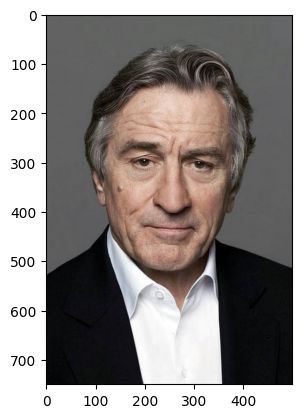

In [11]:
# load the image
image = cv2.imread(r"test-open-eyes.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to RGB
image = np.ascontiguousarray(image)
imgH, imgW, _ = image.shape
 
plt.imshow(image)

In [12]:
# Running inference using static_image_mode 
with mp_facemesh.FaceMesh(
    static_image_mode=True,         # Default=False
    max_num_faces=1,                # Default=1
    refine_landmarks=False,         # Default=False
    min_detection_confidence=0.5,   # Default=0.5
    min_tracking_confidence= 0.5,   # Default=0.5
) as face_mesh:
     
    results = face_mesh.process(image)
 
# Indicates whether any detections are available or not.
print(bool(results.multi_face_landmarks))

True


In [13]:
landmark_0 = results.multi_face_landmarks[0].landmark[0]
print(landmark_0)
 
landmark_0_x = landmark_0.x * imgW 
landmark_0_y = landmark_0.y * imgH
landmark_0_z = landmark_0.z * imgW # according to documentation
 
print()
print("X:", landmark_0_x)
print("Y:", landmark_0_y)
print("Z:", landmark_0_z)
 
print()
print("Total Length of '.landmark':", len(results.multi_face_landmarks[0].landmark))

x: 0.5093799233436584
y: 0.5725576877593994
z: -0.03786652535200119


X: 254.68996167182922
Y: 429.41826581954956
Z: -18.933262676000595

Total Length of '.landmark': 468


In [14]:
def plot(
    *,
    img_dt,
    img_eye_lmks=None,
    img_eye_lmks_chosen=None,
    face_landmarks=None,
    ts_thickness=1,
    ts_circle_radius=2,
    lmk_circle_radius=3,
    name="1",
):
    # For plotting Face Tessellation
    image_drawing_tool = img_dt 
     
     # For plotting all eye landmarks
    image_eye_lmks = img_dt.copy() if img_eye_lmks is None else img_eye_lmks
     
    # For plotting chosen eye landmarks
    img_eye_lmks_chosen = img_dt.copy() if img_eye_lmks_chosen is None else img_eye_lmks_chosen
 
    # Initializing drawing utilities for plotting face mesh tessellation
    connections_drawing_spec = mp_drawing.DrawingSpec(
        thickness=ts_thickness, 
        circle_radius=ts_circle_radius, 
        color=(255, 255, 255)
    )
 
    # Initialize a matplotlib figure.
    fig = plt.figure(figsize=(20, 15))
    fig.set_facecolor("white")
 
    # Draw landmarks on face using the drawing utilities.
    mp_drawing.draw_landmarks(
        image=image_drawing_tool,
        landmark_list=face_landmarks,
        connections=mp_facemesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=connections_drawing_spec,
    )
 
    # Get the object which holds the x, y, and z coordinates for each landmark
    landmarks = face_landmarks.landmark
 
    # Iterate over all landmarks.
    # If the landmark_idx is present in either all_idxs or all_chosen_idxs,
    # get the denormalized coordinates and plot circles at those coordinates.
 
    for landmark_idx, landmark in enumerate(landmarks):
        if landmark_idx in all_idxs:
            pred_cord = denormalize_coordinates(landmark.x, 
                                                landmark.y, 
                                                imgW, imgH)
            cv2.circle(image_eye_lmks, 
                       pred_cord, 
                       lmk_circle_radius, 
                       (255, 255, 255), 
                       -1
                       )
 
        if landmark_idx in all_chosen_idxs:
            pred_cord = denormalize_coordinates(landmark.x, 
                                                landmark.y, 
                                                imgW, imgH)
            cv2.circle(img_eye_lmks_chosen, 
                       pred_cord, 
                       lmk_circle_radius, 
                       (255, 255, 255), 
                       -1
                       )
 
    # Plot post-processed images
    plt.subplot(1, 3, 1)
    plt.title("Face Mesh Tessellation", fontsize=18)
    plt.imshow(image_drawing_tool)
    plt.axis("off")
 
    plt.subplot(1, 3, 2)
    plt.title("All eye landmarks", fontsize=18)
    plt.imshow(image_eye_lmks)
    plt.axis("off")
 
    plt.subplot(1, 3, 3)
    plt.imshow(img_eye_lmks_chosen)
    plt.title("Chosen landmarks", fontsize=18)
    plt.axis("off")
    plt.show()
    plt.close()
    return

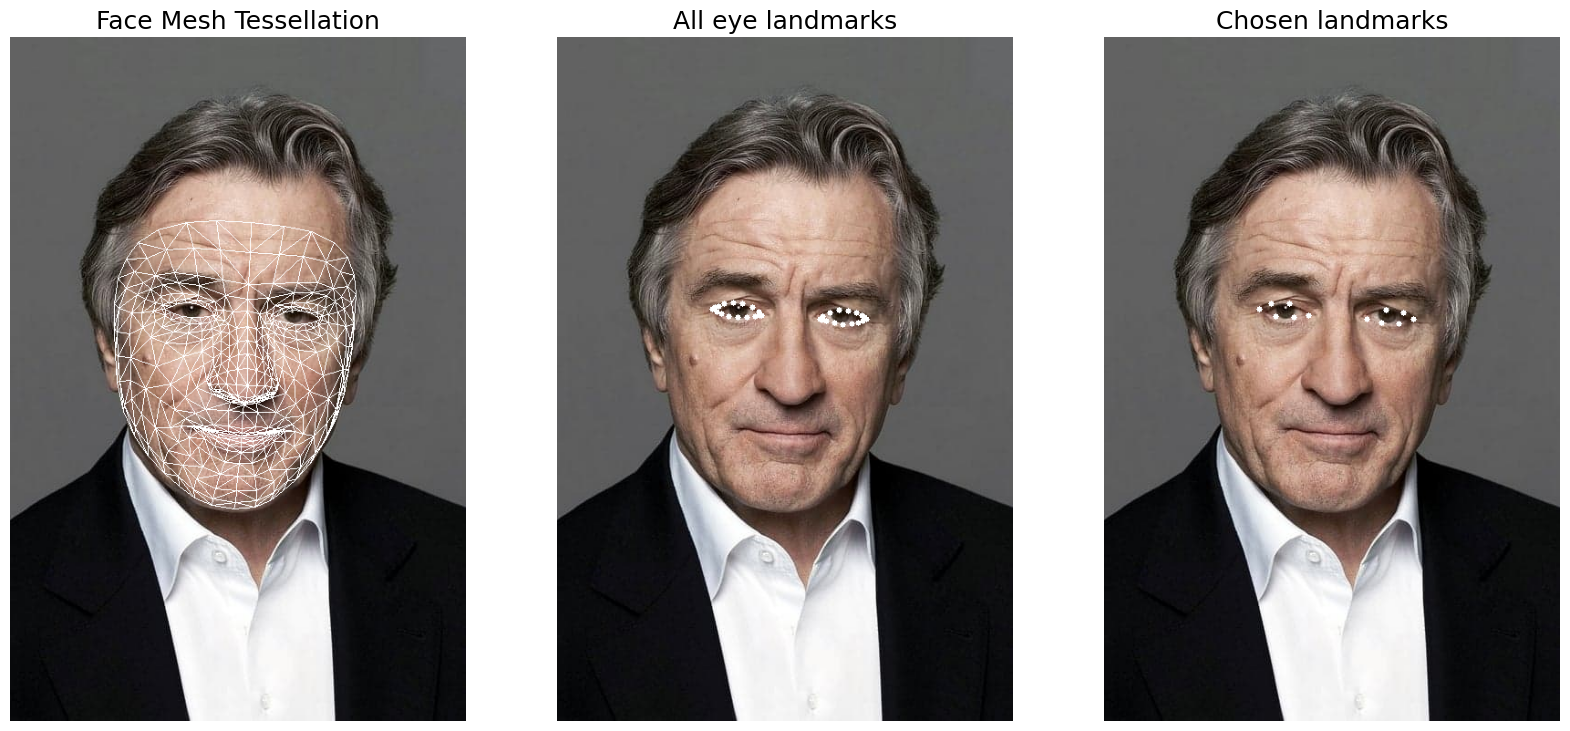

In [15]:
# If detections are available.
if results.multi_face_landmarks:
     
    # Iterate over detections of each face. Here, we have max_num_faces=1, 
    # So there will be at most 1 element in 
    # the 'results.multi_face_landmarks' list            
    # Only one iteration is performed.
 
    for face_id, face_landmarks in enumerate(results.multi_face_landmarks):    
        _ = plot(img_dt=image.copy(), face_landmarks=face_landmarks)

In [16]:
def distance(point_1, point_2):
    """Calculate l2-norm between two points"""
    dist = sum([(i - j) ** 2 for i, j in zip(point_1, point_2)]) ** 0.5
    return dist

In [17]:
def get_ear(landmarks, refer_idxs, frame_width, frame_height):
    """
    Calculate Eye Aspect Ratio for one eye.
 
    Args:
        landmarks: (list) Detected landmarks list
        refer_idxs: (list) Index positions of the chosen landmarks
                            in order P1, P2, P3, P4, P5, P6
        frame_width: (int) Width of captured frame
        frame_height: (int) Height of captured frame
 
    Returns:
        ear: (float) Eye aspect ratio
    """
    try:
        # Compute the euclidean distance between the horizontal
        coords_points = []
        for i in refer_idxs:
            lm = landmarks[i]
            coord = denormalize_coordinates(lm.x, lm.y, 
                                             frame_width, frame_height)
            coords_points.append(coord)
 
        # Eye landmark (x, y)-coordinates
        P2_P6 = distance(coords_points[1], coords_points[5])
        P3_P5 = distance(coords_points[2], coords_points[4])
        P1_P4 = distance(coords_points[0], coords_points[3])
 
        # Compute the eye aspect ratio
        ear = (P2_P6 + P3_P5) / (2.0 * P1_P4)
 
    except:
        ear = 0.0
        coords_points = None
 
    return ear, coords_points

In [18]:
def calculate_avg_ear(landmarks, left_eye_idxs, right_eye_idxs, image_w, image_h):
    """Calculate Eye aspect ratio"""
 
    left_ear, left_lm_coordinates = get_ear(
                                      landmarks, 
                                      left_eye_idxs, 
                                      image_w, 
                                      image_h
                                    )
    right_ear, right_lm_coordinates = get_ear(
                                      landmarks, 
                                      right_eye_idxs, 
                                      image_w, 
                                      image_h
                                    )
    Avg_EAR = (left_ear + right_ear) / 2.0
 
    return Avg_EAR, (left_lm_coordinates, right_lm_coordinates)

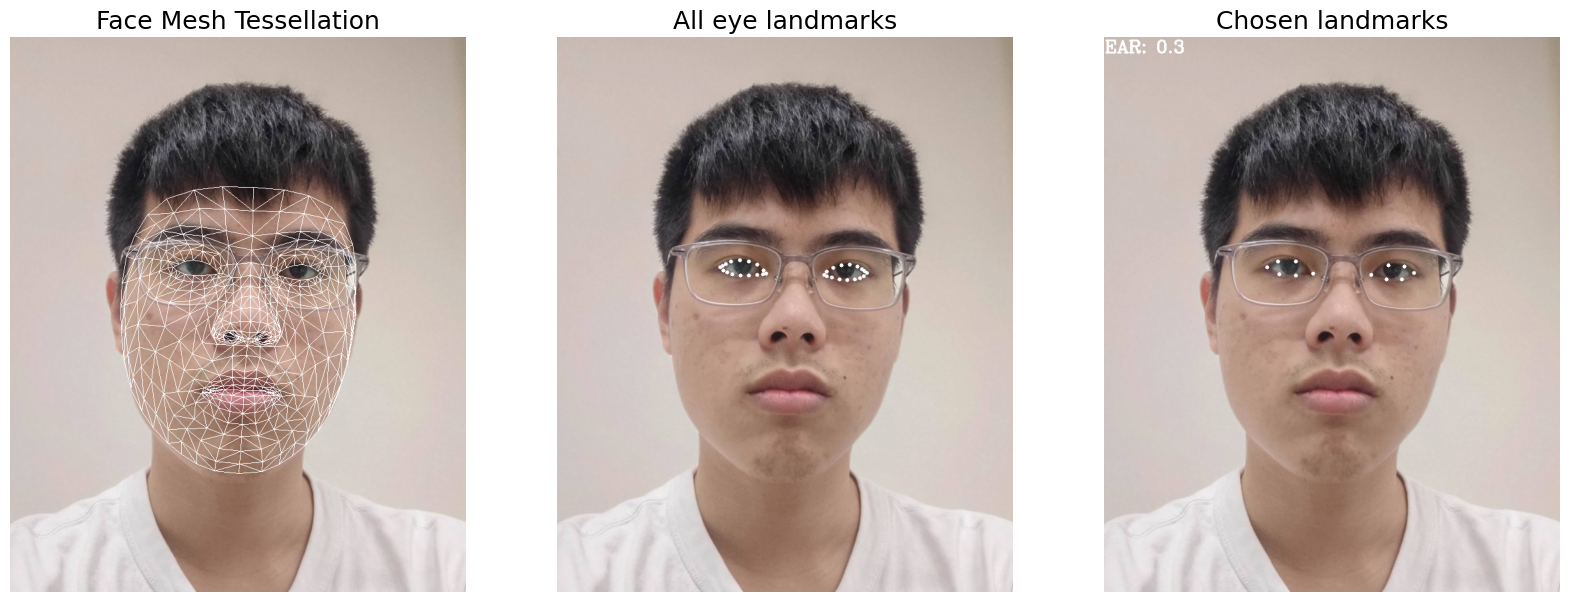

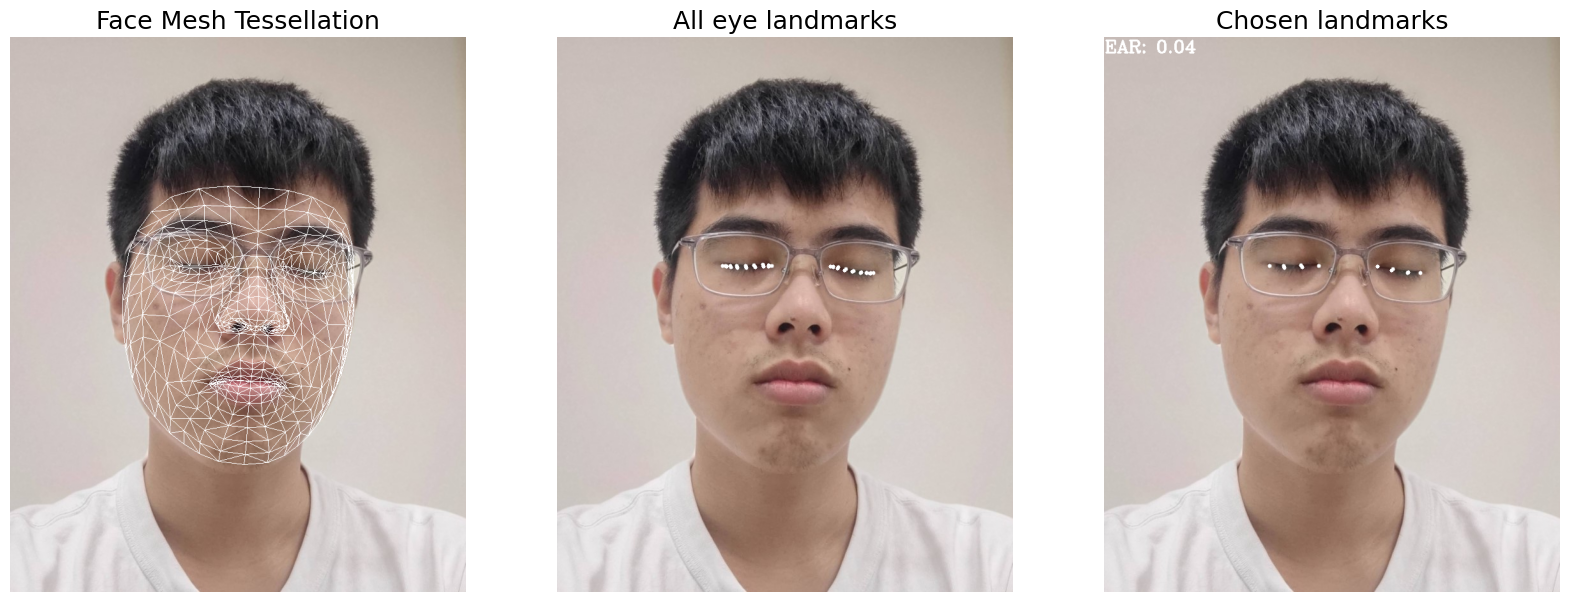

In [25]:
image_eyes_open  = cv2.imread("4825.jpg")[:, :, ::-1]
image_eyes_close = cv2.imread("4824.jpg")[:, :, ::-1]
 
for idx, image in enumerate([image_eyes_open, image_eyes_close]):
    
    image = np.ascontiguousarray(image)
    imgH, imgW, _ = image.shape
 
    # Creating a copy of the original image for plotting the EAR value
    custom_chosen_lmk_image = image.copy()
 
    # Running inference using static_image_mode
    with mp_facemesh.FaceMesh(refine_landmarks=True) as face_mesh:
        results = face_mesh.process(image).multi_face_landmarks
 
        # If detections are available.
        if results:
            for face_id, face_landmarks in enumerate(results):
                landmarks = face_landmarks.landmark
                EAR, _ = calculate_avg_ear(
                          landmarks, 
                          chosen_left_eye_idxs, 
                          chosen_right_eye_idxs, 
                          imgW, 
                          imgH
                      )
 
                # Print the EAR value on the custom_chosen_lmk_image.
                cv2.putText(custom_chosen_lmk_image, 
                            f"EAR: {round(EAR, 2)}", (1, 24),
                            cv2.FONT_HERSHEY_COMPLEX, 
                            0.9, (255, 255, 255), 2
                )
              
                plot(img_dt=image.copy(),
                     img_eye_lmks_chosen=custom_chosen_lmk_image,
                     face_landmarks=face_landmarks,
                     ts_thickness=1, 
                     ts_circle_radius=3, 
                     lmk_circle_radius=3
                )

# 專題圖片來源

# TEST

In [ ]:
import numpy as np
import cv2
import time
  
# creating the videocapture object
# and reading from the input file
# Change it to 0 if reading from webcam
cap = cv2.VideoCapture(0)
  
# Set the frame rate to 10 FPS
frame_rate = 7
prev_frame_time = 0

while(cap.isOpened()):
  
    # Calculate the time elapsed since the previous frame
    time_elapsed = time.time() - prev_frame_time

    # If the time elapsed is greater than the desired frame interval
    if time_elapsed > 1./frame_rate:
        prev_frame_time = time.time()

        # Capture frame-by-frame
        ret, frame = cap.read()
  
        # If video finished or no Video Input
        if not ret:
            break
  
        # Our operations on the frame come here
        gray = frame
  
        # resizing the frame size according to our need
        gray = cv2.resize(gray, (500, 300))
  
        # font which we will be using to display FPS
        font = cv2.FONT_HERSHEY_SIMPLEX
  
        # Calculating the fps
        fps = 1/time_elapsed
        fps = int(fps)
  
        # converting the fps to string so that we can display it on frame
        fps = str(fps)
  
        # putting the FPS count on the frame
        cv2.putText(gray, fps, (7, 70), font, 3, (100, 255, 0), 3, cv2.LINE_AA)
  
        # displaying the frame with fps
        cv2.imshow('frame', gray)
  
        # press 'Q' if you want to exit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
  
# When everything done, release the capture
cap.release()
# Destroy the all windows now
cv2.destroyAllWindows()